# Customer Revenue Prediction

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.
This notebook will analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset from Kaggle competition ['Google Analytics Customer Revenue Prediction'](https://www.kaggle.com/c/ga-customer-revenue-prediction) to predict revenue per customer. 

### About the dataset:

Each row in the dataset is one visit to the store. Targeted outputs are prediction of the natural log of the sum of all transactions per user.

The data fields in the given files are

* fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

Note: some of the fields are in json format, the dataset size is very large. The train and test datasets used in this analysis is a cvs file with json flattened from Kaggle [json flattened csv data](https://www.kaggle.com/colinpearse/ga-analytics-with-json-columns)(thanks to Collin!).

In [1]:
import os
import gc   # garbage collector
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

### Load Datasets and Extract Train_Test sets

In [2]:
# some repeated datetime and starttime process
train = pd.read_csv('./Output/train_p.csv')
train.drop(['Unnamed: 0'],axis=1, inplace=True)
train['date'] = pd.to_datetime(train['date'])
train['visitStartTime'] = train['visitStartTime']. apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%-H'))

test = pd.read_csv('./Output/test_p.csv')
test.drop(['Unnamed: 0'],axis=1, inplace=True)
test['date'] = pd.to_datetime(test['date'])
test['visitStartTime'] = test['visitStartTime']. apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%-H'))

In [3]:
# data visualization showed weekdays have more user activities than weekend; 
#there are more activities during special occasions like Velentine's day. These can be important features to include for the model training
train['weekday']=train['date'].apply(lambda x: x.weekday())
test['weekday']=test['date'].apply(lambda x: x.weekday())

train['mon_day'] = train['date'].apply(lambda x: str(f"{x:%m}")+str(f"{x:%d}"))
test['mon_day'] = test['date'].apply(lambda x:  str(f"{x:%m}")+str(f"{x:%d}"))

train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,geoNetwork.networkDomain,geoNetwork.subContinent,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source,weekday,mon_day
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,8,Chrome,desktop,False,...,ttnet.com.tr,Western Asia,1,1.0,1.0,0.0,organic,google,4,0902
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,22,Firefox,desktop,False,...,dodo.net.au,Australasia,1,1.0,1.0,0.0,organic,google,4,0902
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,18,Chrome,desktop,False,...,unknown.unknown,Southern Europe,1,1.0,1.0,0.0,organic,google,4,0902
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,22,UC Browser,desktop,False,...,unknown.unknown,Southeast Asia,1,1.0,1.0,0.0,organic,google,4,0902
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,6,Chrome,mobile,True,...,unknown.unknown,Northern Europe,1,NaN,1.0,0.0,organic,google,4,0902


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 23 columns):
channelGrouping              903653 non-null object
date                         903653 non-null datetime64[ns]
fullVisitorId                903653 non-null object
sessionId                    903653 non-null object
visitId                      903653 non-null int64
visitNumber                  903653 non-null int64
visitStartTime               903653 non-null object
device.browser               903645 non-null object
device.deviceCategory        903653 non-null object
device.isMobile              903653 non-null bool
device.operatingSystem       898958 non-null object
geoNetwork.continent         902185 non-null object
geoNetwork.country           902185 non-null object
geoNetwork.networkDomain     658772 non-null object
geoNetwork.subContinent      902185 non-null object
totals.hits                  903653 non-null int64
totals.newVisits             703060 non-null float64
t

In [5]:
print(train.columns)

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.medium', 'trafficSource.source', 'weekday', 'mon_day'],
      dtype='object')


In [6]:
pop_cols = ['date', 'fullVisitorId', 'sessionId', 'visitId','totals.transactionRevenue']
feature_cols = [col for col in train.columns if col not in pop_cols]
print('{} features will be used to train model, including: \n{}'.format(len(feature_cols), feature_cols))

18 features will be used to train model, including: 
['channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.medium', 'trafficSource.source', 'weekday', 'mon_day']


In [7]:
df=train[feature_cols]
col_type = df.columns.to_series().groupby(df.dtypes).groups
print(col_type)

{dtype('bool'): Index(['device.isMobile'], dtype='object'), dtype('int64'): Index(['visitNumber', 'totals.hits', 'weekday'], dtype='object'), dtype('float64'): Index(['totals.newVisits', 'totals.pageviews'], dtype='object'), dtype('O'): Index(['channelGrouping', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent',
       'trafficSource.medium', 'trafficSource.source', 'mon_day'],
      dtype='object')}


In [8]:
#convert categorical features to int type before constructing Dataset for LGB model
cat_cols = ['device.isMobile', 'channelGrouping', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent',
       'trafficSource.medium', 'trafficSource.source', 'mon_day']

for col in cat_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train[col].tolist()+test[col].tolist())
    train[col]=le.transform(train[col].tolist())
    test[col]=le.transform(test[col].tolist())

In [9]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,geoNetwork.networkDomain,geoNetwork.subContinent,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source,weekday,mon_day
0,4,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,22,34,0,0,...,37454,20,1,1.0,1.0,0.0,5,207,4,244
1,4,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,15,42,0,0,...,10097,0,1,1.0,1.0,0.0,5,207,4,244
2,4,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,10,34,0,0,...,38725,18,1,1.0,1.0,0.0,5,207,4,244
3,4,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,15,78,0,0,...,38725,15,1,1.0,1.0,0.0,5,207,4,244
4,4,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,20,34,1,1,...,38725,12,1,NaN,1.0,0.0,5,207,4,244


In [10]:
X_train = train[feature_cols]
X_test = test[feature_cols]
y_train = train['totals.transactionRevenue'].apply(lambda x: np.log(x) if x> 0 else 0)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, random_state=0)

### Light Gradient Boosting Baseline Model Building and Evaluation

In [11]:
def modelfit(X_train1, y_train1, X_val, y_val):
    train_data = lgb.Dataset(X_train1, label=y_train1)
    val_data = lgb.Dataset(X_val, label=y_val)

    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : 31,
    "max_depth" : 5,
    "min_data_in_leaf": 20,
    "learning_rate" : 0.1,
    "bagging_fraction" : 1,
    "feature_fraction" : 1
    }

    bst = lgb.train(params, train_data, 1000, valid_sets=[val_data], early_stopping_rounds=300, verbose_eval=300)

    pred_val = bst.predict(X_val, num_iteration=bst.best_iteration)
    val_rmse=round(np.sqrt(metrics.mean_squared_error(y_val, pred_val)),5)
    return(val_rmse)
modelfit(X_train1, y_train1, X_val, y_val)   

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62404
Early stopping, best iteration is:
[215]	valid_0's rmse: 1.62283


1.62283

### Model Parameter Optimization 1 - learning rate

In [12]:
def modelfit_param(X_train1, y_train1, X_val, y_val,nl,md,mdil,lr,bf,ff):
    train_data = lgb.Dataset(X_train1, label=y_train1)
    val_data = lgb.Dataset(X_val, label=y_val)

    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : nl,
    "max_depth" : md,
    "min_data_in_leaf": mdil,
    "learning_rate" : lr,
    "bagging_fraction" : bf,
    "feature_fraction" : ff
    }

    bst = lgb.train(params, train_data, 1000, valid_sets=[val_data], early_stopping_rounds=300, verbose_eval=300)

    pred_val = bst.predict(X_val, num_iteration=bst.best_iteration)
    val_rmse=round(np.sqrt(metrics.mean_squared_error(y_val, pred_val)),5)
    return(val_rmse)

LR_score = dict()
for lr in [0.01,0.03,0.05,0.07,0.1,0.15,0.2]:
    LR_score[lr] = modelfit_param(X_train1, y_train1, X_val, y_val,31,5,20,lr,1,1)
Model_summary = pd.DataFrame(columns = ["num_leaves", "max_depth","min_data_in_leaf","learning_rate","bagging_fraction","feature_fraction","val_rmse"])
for lr,key in LR_score.items():
    param = {
        "num_leaves" : 31,
        "max_depth" : 5,
        "min_data_in_leaf": 20,
        "learning_rate" : lr,
        "bagging_fraction" : 1,
        "feature_fraction" : 1,
        "val_rmse": key
        }
    
    Model_summary=Model_summary.append(param,ignore_index=True)
Model_summary

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.6633
[600]	valid_0's rmse: 1.6413
[900]	valid_0's rmse: 1.63102
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.62931
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.632
[600]	valid_0's rmse: 1.62341
[900]	valid_0's rmse: 1.62339
Early stopping, best iteration is:
[665]	valid_0's rmse: 1.62248
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62452
[600]	valid_0's rmse: 1.62171
[900]	valid_0's rmse: 1.62248
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.62169
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62217
[600]	valid_0's rmse: 1.62367
Early stopping, best iteration is:
[327]	valid_0's rmse: 1.62157
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62404
Early stopping, best iteration is:
[215]	valid_0's rmse

,num_leaves,max_depth,min_data_in_leaf,learning_rate,bagging_fraction,feature_fraction,val_rmse
0,31.0,5.0,20.0,0.01,1.0,1.0,1.62931
1,31.0,5.0,20.0,0.03,1.0,1.0,1.62248
2,31.0,5.0,20.0,0.05,1.0,1.0,1.62169
3,31.0,5.0,20.0,0.07,1.0,1.0,1.62157
4,31.0,5.0,20.0,0.10,1.0,1.0,1.62283
5,31.0,5.0,20.0,0.15,1.0,1.0,1.62426
6,31.0,5.0,20.0,0.20,1.0,1.0,1.62415


### Model Parameter Optimization 2 - max_depth (Fix learning rate=0.07)

In [13]:
MD_score = dict()
for md in [6,7,8]:
    MD_score[md] = modelfit_param(X_train1, y_train1, X_val, y_val,31,md,20,0.07,1,1)
for md,key in MD_score.items():
    param = {
        "num_leaves" : 31,
        "max_depth" : md,
        "min_data_in_leaf": 20,
        "learning_rate" : 0.07,
        "bagging_fraction" : 1,
        "feature_fraction" : 1,
        "val_rmse": key
        }
    
    Model_summary=Model_summary.append(param,ignore_index=True)
Model_summary

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61962
Early stopping, best iteration is:
[296]	valid_0's rmse: 1.61947
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61869
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.61812
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61938
Early stopping, best iteration is:
[207]	valid_0's rmse: 1.61824


,num_leaves,max_depth,min_data_in_leaf,learning_rate,bagging_fraction,feature_fraction,val_rmse
0,31.0,5.0,20.0,0.01,1.0,1.0,1.62931
1,31.0,5.0,20.0,0.03,1.0,1.0,1.62248
2,31.0,5.0,20.0,0.05,1.0,1.0,1.62169
3,31.0,5.0,20.0,0.07,1.0,1.0,1.62157
4,31.0,5.0,20.0,0.10,1.0,1.0,1.62283
5,31.0,5.0,20.0,0.15,1.0,1.0,1.62426
6,31.0,5.0,20.0,0.20,1.0,1.0,1.62415
7,31.0,6.0,20.0,0.07,1.0,1.0,1.61947
8,31.0,7.0,20.0,0.07,1.0,1.0,1.61812
9,31.0,8.0,20.0,0.07,1.0,1.0,1.61824


### Model Parameter Optimization 3 - num_leaves (Fix learning rate=0.07, max_depth=7)

In [14]:
NL_score = dict()
for nl in [40,60,80,100]:
    NL_score[nl] = modelfit_param(X_train1, y_train1, X_val, y_val,nl,7,20,0.07,1,1)
for nl,key in NL_score.items():
    param = {
        "num_leaves" : nl,
        "max_depth" : 7,
        "min_data_in_leaf": 20,
        "learning_rate" : 0.03,
        "bagging_fraction" : 1,
        "feature_fraction" : 1,
        "val_rmse": key
        }
    
    Model_summary=Model_summary.append(param,ignore_index=True)
Model_summary

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62075
Early stopping, best iteration is:
[228]	valid_0's rmse: 1.6195
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62219
Early stopping, best iteration is:
[219]	valid_0's rmse: 1.61991
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.6226
Early stopping, best iteration is:
[176]	valid_0's rmse: 1.6207
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62003
Early stopping, best iteration is:
[214]	valid_0's rmse: 1.61913


,num_leaves,max_depth,min_data_in_leaf,learning_rate,bagging_fraction,feature_fraction,val_rmse
0,31.0,5.0,20.0,0.01,1.0,1.0,1.62931
1,31.0,5.0,20.0,0.03,1.0,1.0,1.62248
2,31.0,5.0,20.0,0.05,1.0,1.0,1.62169
3,31.0,5.0,20.0,0.07,1.0,1.0,1.62157
4,31.0,5.0,20.0,0.10,1.0,1.0,1.62283
5,31.0,5.0,20.0,0.15,1.0,1.0,1.62426
6,31.0,5.0,20.0,0.20,1.0,1.0,1.62415
7,31.0,6.0,20.0,0.07,1.0,1.0,1.61947
8,31.0,7.0,20.0,0.07,1.0,1.0,1.61812
9,31.0,8.0,20.0,0.07,1.0,1.0,1.61824


### Model Parameter Optimization 4 - bagging_fraction  (Fix learning rate=0.07, max_depth=7, num_leaves=31)

In [15]:
BF_score = dict()
for bf in [0.7,0.8,0.9]:
    BF_score[bf] = modelfit_param(X_train1, y_train1, X_val, y_val,31,7,20,0.07,bf,1)
for bf,key in BF_score.items():
    param = {
        "num_leaves" : 31,
        "max_depth" : 7,
        "min_data_in_leaf": 20,
        "learning_rate" : 0.07,
        "bagging_fraction" : bf,
        "feature_fraction" : 1,
        "val_rmse": key
        }
    
    Model_summary=Model_summary.append(param,ignore_index=True)
Model_summary

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61869
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.61812
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61869
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.61812
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61869
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.61812


,num_leaves,max_depth,min_data_in_leaf,learning_rate,bagging_fraction,feature_fraction,val_rmse
0,31.0,5.0,20.0,0.01,1.0,1.0,1.62931
1,31.0,5.0,20.0,0.03,1.0,1.0,1.62248
2,31.0,5.0,20.0,0.05,1.0,1.0,1.62169
3,31.0,5.0,20.0,0.07,1.0,1.0,1.62157
4,31.0,5.0,20.0,0.10,1.0,1.0,1.62283
5,31.0,5.0,20.0,0.15,1.0,1.0,1.62426
6,31.0,5.0,20.0,0.20,1.0,1.0,1.62415
7,31.0,6.0,20.0,0.07,1.0,1.0,1.61947
8,31.0,7.0,20.0,0.07,1.0,1.0,1.61812
9,31.0,8.0,20.0,0.07,1.0,1.0,1.61824


### Model Parameter Optimization 5 -  feature_fraction (Fix learning rate=0.07, max_depth=7, num_leaves=31, bagging_fraction=1)

In [16]:
FF_score = dict()
for ff in [0.7,0.8,0.9]:
    FF_score[ff] = modelfit_param(X_train1, y_train1, X_val, y_val,31,7,20,0.07,1,ff)
for ff,key in FF_score.items():
    param = {
        "num_leaves" : 31,
        "max_depth" : 7,
        "min_data_in_leaf": 20,
        "learning_rate" : 0.07,
        "bagging_fraction" : 1,
        "feature_fraction" : ff,
        "val_rmse": key
        }
    
    Model_summary=Model_summary.append(param,ignore_index=True)
Model_summary

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.6203
[600]	valid_0's rmse: 1.62299
Early stopping, best iteration is:
[382]	valid_0's rmse: 1.61899
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62128
Early stopping, best iteration is:
[252]	valid_0's rmse: 1.62081
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61897
Early stopping, best iteration is:
[246]	valid_0's rmse: 1.61841


,num_leaves,max_depth,min_data_in_leaf,learning_rate,bagging_fraction,feature_fraction,val_rmse
0,31.0,5.0,20.0,0.01,1.0,1.0,1.62931
1,31.0,5.0,20.0,0.03,1.0,1.0,1.62248
2,31.0,5.0,20.0,0.05,1.0,1.0,1.62169
3,31.0,5.0,20.0,0.07,1.0,1.0,1.62157
4,31.0,5.0,20.0,0.10,1.0,1.0,1.62283
5,31.0,5.0,20.0,0.15,1.0,1.0,1.62426
6,31.0,5.0,20.0,0.20,1.0,1.0,1.62415
7,31.0,6.0,20.0,0.07,1.0,1.0,1.61947
8,31.0,7.0,20.0,0.07,1.0,1.0,1.61812
9,31.0,8.0,20.0,0.07,1.0,1.0,1.61824


### Model Parameter Optimization 6 -  min_data_in_leaf (Fix learning rate=0.07, max_depth=7, num_leaves=31, bagging_fraction=1, feature_fraction=1)

In [17]:
MDIL_score = dict()
for mdil in [15,25,30,35]:
    MDIL_score[mdil] = modelfit_param(X_train1, y_train1, X_val, y_val,31,7,mdil,0.07,1,1)
for mdil,key in MDIL_score.items():
    param = {
        "num_leaves" : 31,
        "max_depth" : 7,
        "min_data_in_leaf": mdil,
        "learning_rate" : 0.07,
        "bagging_fraction" : 1,
        "feature_fraction" : 1,
        "val_rmse": key
        }
    
    Model_summary=Model_summary.append(param,ignore_index=True)
Model_summary

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61912
Early stopping, best iteration is:
[207]	valid_0's rmse: 1.61849
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61887
Early stopping, best iteration is:
[275]	valid_0's rmse: 1.61857
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61989
Early stopping, best iteration is:
[263]	valid_0's rmse: 1.61924
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62006
[600]	valid_0's rmse: 1.62208
Early stopping, best iteration is:
[389]	valid_0's rmse: 1.61959


,num_leaves,max_depth,min_data_in_leaf,learning_rate,bagging_fraction,feature_fraction,val_rmse
0,31.0,5.0,20.0,0.01,1.0,1.0,1.62931
1,31.0,5.0,20.0,0.03,1.0,1.0,1.62248
2,31.0,5.0,20.0,0.05,1.0,1.0,1.62169
3,31.0,5.0,20.0,0.07,1.0,1.0,1.62157
4,31.0,5.0,20.0,0.10,1.0,1.0,1.62283
5,31.0,5.0,20.0,0.15,1.0,1.0,1.62426
6,31.0,5.0,20.0,0.20,1.0,1.0,1.62415
7,31.0,6.0,20.0,0.07,1.0,1.0,1.61947
8,31.0,7.0,20.0,0.07,1.0,1.0,1.61812
9,31.0,8.0,20.0,0.07,1.0,1.0,1.61824


### K-fold Cross Validation

In [18]:
def modelfit_cv(X_train1, y_train1, X_val_c, y_val_c, X_test):
    train_data = lgb.Dataset(X_train1, label=y_train1)
    val_data = lgb.Dataset(X_val, label=y_val)

    params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : 31,
    "max_depth" : 7,
    "min_data_in_leaf": 20,
    "learning_rate" : 0.07,
    "bagging_fraction" : 1,
    "feature_fraction" : 1
    }

    bst = lgb.train(params, train_data, 1000, valid_sets=[val_data], early_stopping_rounds=300, verbose_eval=300)

    pred_val = bst.predict(X_val, num_iteration=bst.best_iteration)
    val_rmse=round(np.sqrt(metrics.mean_squared_error(y_val, pred_val)),5)
    y_test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
    return(val_rmse,y_test_pred)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_score = []
y_pred = []
for train_index, val_index in kf.split(X_train, y_train):
    X_train1, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train1, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    score,y_test_pred = modelfit_cv(X_train1, y_train1, X_val, y_val,X_test)
    
    val_score.append(score)
    y_pred.append(y_test_pred)
val_rmse_5fold = round(np.mean(val_score),5)
y_pred_5fold = np.mean(y_pred,axis=0)

print(val_rmse_5fold,y_pred_5fold)

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61927
Early stopping, best iteration is:
[201]	valid_0's rmse: 1.61901
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.61984
Early stopping, best iteration is:
[213]	valid_0's rmse: 1.61871
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.62533
[600]	valid_0's rmse: 1.62704
Early stopping, best iteration is:
[371]	valid_0's rmse: 1.62391
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.64503
Early stopping, best iteration is:
[289]	valid_0's rmse: 1.64491
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.60785
[600]	valid_0's rmse: 1.6083
Early stopping, best iteration is:
[385]	valid_0's rmse: 1.60676
1.62266 [  3.15262098e-03   1.04251258e-03   4.20521517e-03 ...,   6.08186770e-01
  -1.43363178e-01  -1.15491478e+00]


### Finalize Prediction Results and Visualize Feature Importance

In [19]:
customer_pred = pd.DataFrame(columns = ['user ID', 'pred_rev_log'])
customer_pred['user ID'] = test.fullVisitorId
customer_pred['pred_rev_log'] = y_pred_5fold
customer_pred['pred_rev'] = customer_pred['pred_rev_log'].apply(lambda x: np.exp(x) if x>0 else 0)
customer_pred.head()

,user ID,pred_rev_log,pred_rev
0,6167871330617112363,0.003153,1.003158
1,0643697640977915618,0.001043,1.001043
2,6059383810968229466,0.004205,1.004214
3,2376720078563423631,0.000831,1.000831
4,2314544520795440038,0.001176,1.001177


In [20]:
Final = customer_pred.groupby('user ID')['pred_rev'].sum().reset_index(name='Sum_revenue')
Final['Sum_revenue_log']=Final['Sum_revenue'].apply(lambda x: np.log(x) if x>0 else 0)
Final.drop(columns='Sum_revenue', inplace=True)
Final.head()

,user ID,Sum_revenue_log
0,259678714014,0.833565
1,3038793126460,0.002659
2,9663019041506,0.002542
3,10438463470860,0.003260
4,10992980461157,0.000000


Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 1.60785
[600]	valid_0's rmse: 1.6083
Early stopping, best iteration is:
[385]	valid_0's rmse: 1.60676


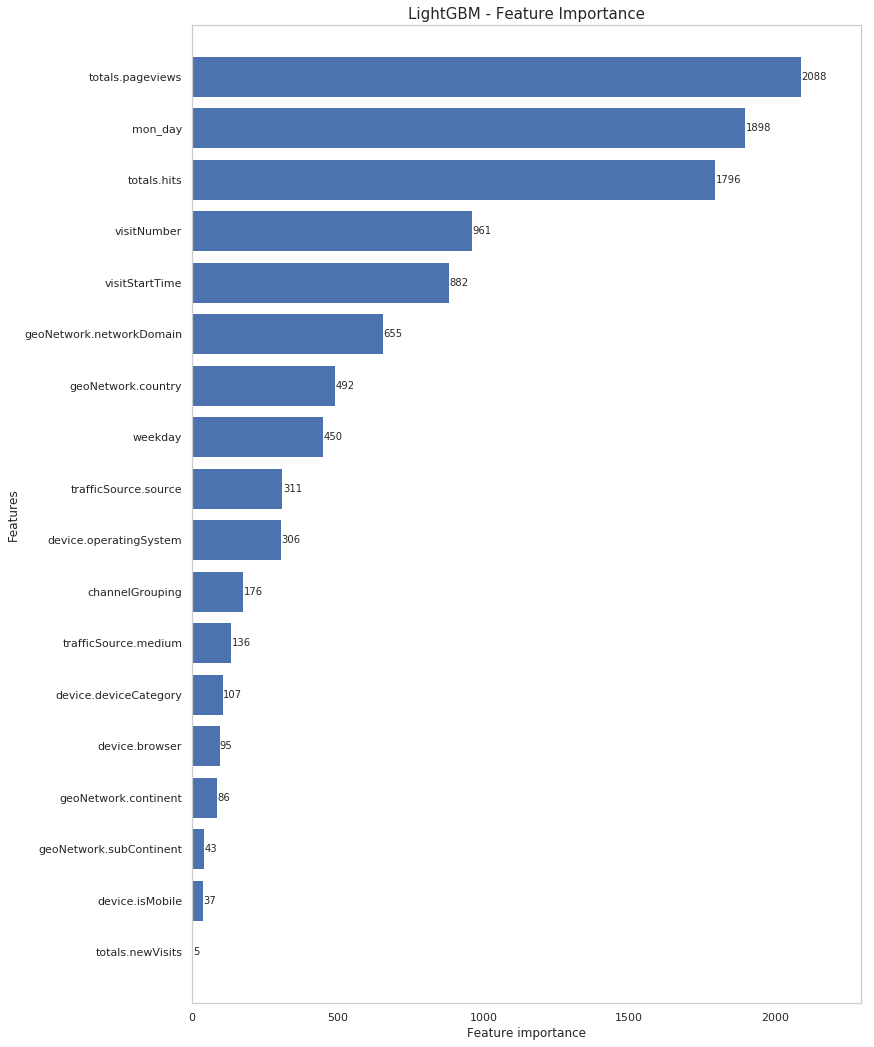

In [21]:
train_data = lgb.Dataset(X_train1, label=y_train1)
val_data = lgb.Dataset(X_val, label=y_val)
params = {
            "objective" : "regression",
            "metric" : "rmse", 
            "num_leaves" : 31,
            "max_depth" : 7,
            "min_data_in_leaf": 20,
            "learning_rate" : 0.07,
            "bagging_fraction" : 1,
            "feature_fraction" : 1
            }

bst = lgb.train(params, train_data, 1000, valid_sets=[val_data], early_stopping_rounds=300, verbose_eval=300)

fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(bst, max_num_features=30, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()